In [1]:
## notebook setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/homes/sep/haipeng/develop/SWIT-1.0/dev/toolbox-dev/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import HTML
#matplotlib.use('Qt5Agg')   # 'agg'

from survey import Model, Source, Receiver, System
from utils import source_wavelet
from solver import Solver
from tools import load_float, save_float

In [6]:
help(Receiver)

Help on class Receiver in module survey:

class Receiver(builtins.object)
 |  Receiver(coord, comp)
 |  
 |  Receiver class describes the receiver geometry
 |  
 |  parameters:
 |  ----------
 |      coord: 2d array
 |          coordinates of receivers, in meters
 |      comp: str
 |          components of receivers, 'vx', 'vz', 'p'
 |  
 |  Methods defined here:
 |  
 |  __check__(self)
 |      check the receiver parameters
 |  
 |  __init__(self, coord, comp)
 |      initialize receiver class
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [20]:
work_path = '/scr2/haipeng/SWIT-1.1/02_adjoint_test/'   # Working path
mpi_cpu_num   = 49                                     # MPI process for fd2dmpi

### model setup
nx,  nz, pml = [401,  401, 60]                     # Grid number along x and z directions, Grid number for PML layers (use a large one)
dx,  dt,  nt = [10, 0.001, 1001]                   # Grid size, time interval, and time step

# velocity and density
vp_true = np.zeros((nx, nz))
vp_init = np.zeros((nx, nz))
rho_true = np.zeros((nx, nz))
rho_init = np.zeros((nx, nz))

# true model
modelpath = '/homes/sep/haipeng/develop/SWIT-1.0/examples/case-01-marmousi2/model/'
# vp_true = np.loadtxt(modelpath + 'Marmousi_481_141_25m.dat')
# rho_true = np.power(vp_true, 0.25) * 310   # density models, (Gardner, 1974)


# vp_true = np.random.uniform(low=3500, high=4000, size=(nx*nz,)).reshape(nx, nz)

vp_true = np.ones((nx, nz)) * 4000
rho_true = np.power(vp_true, 0.25) * 310   # density models, (Gardner, 1974)


### sources setup 
f0    = 5.0                                              # Dominant frequency in Hz
amp0  = 1.0e20                                              # Amplitude of the source wavelet
# srcxz = np.loadtxt(modelpath + 'source_coordinate.dat')  # Source coordinates
srcn  = 1                                                # Source number along x axis
wavelet = np.zeros((srcn, nt))                          # Source wavelet
srcxz = np.zeros((srcn, 2))   
srcxz[0,0] = 2000
srcxz[0,1] = 2000

src = source_wavelet(amp0, nt, dt, f0, 'Ricker')

for isrc in range(srcn):
    wavelet[isrc,:] = source_wavelet(amp0, nt, dt, f0, 'ricker')


recn = 2
recxz = np.zeros((recn, 2))   
recxz[0,0] = 2000
recxz[0,1] = 2000
recxz[1,0] = 3000
recxz[1,1] = 2000
recxz = [recxz]
    
### receivers setup
# temp = np.loadtxt(modelpath + 'receiver_coordinate.dat') # Receiver coordinates
# recn = temp.shape[0]                                    # Receiver number
# recxz = []                         # Receiver positions
# for isrc in range(srcn):
#     # nrec = isrc * 10 + 1 
#     # recxz_isrc = np.zeros((nrec, 2)) 
#     # recxz_isrc[:,0] = temp[0:nrec,0]                          # Receiver x position (m)
#     # recxz_isrc[:,1] = temp[0:nrec,1]                          # Receiver z position (m)
#     # recxz.append(recxz_isrc) 
#     nrec = nx 
#     recxz_isrc = np.zeros((nrec, 2)) 
#     recxz_isrc[:,0] = temp[0:nrec,0]                          # Receiver x position (m)
#     recxz_isrc[:,1] = temp[0:nrec,1]                          # Receiver z position (m)
#     recxz.append(recxz_isrc) 

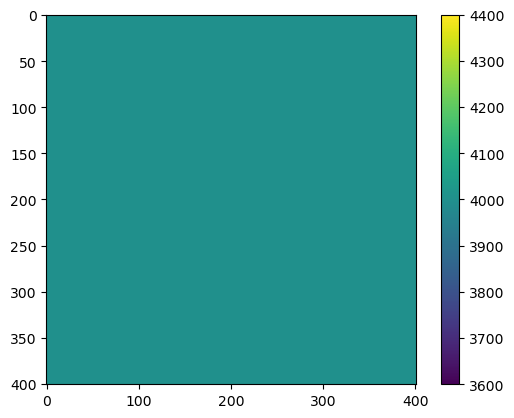

In [21]:
plt.imshow(vp_true)
plt.colorbar()

In [28]:
## configuration
config = System(work_path, mpi_cpu_num)

## model
model = Model(nx, nz, dx, dt, nt, pml, vp_true, rho_true)

## source
source = Source(srcxz, wavelet, f0)

## receiver 
receiver = Receiver(recxz, 'p')

## solver
solver = Solver(config, model, source, receiver)

System Warning: number of mpi processes 49 exceeds the number of CPUs
System Warning: number of mpi processes is reset to 24.
Survey Warning: number of mpi processes {} exceeds the number of sources {}, reset to source number

Solver information:
    Model dimension   : nx = 401, nz = 401, dx = 10 m, x = 0 ~ 4.00 km,  z = 0 ~ 4.00 km
    Data  dimension   : nt = 1001, dt = 1.00 ms, t = 0 ~ 1.00 s
    Data acquisition  : 1 sources, p-component receivers
    P-wave velocity   : 4000.00 ~ 4000.00 m/s
    MPI information   : 1 tasks run in parallel


In [29]:
solver.run(simu_type = 'forward', simu_tag = 'obs', save_snap = False)
obs_trace = load_float(config.path + 'data/obs/src1/sg.bin').reshape(-1, nt)

In [30]:
# save adjoint source
adj_src = np.zeros((2, nt))
adj_src[1,:] = obs_trace[1,:]
save_float(config.path + 'config/wavelet/src1_adj.bin', adj_src)

In [31]:
solver.run(simu_type = 'adjoint', simu_tag = 'adj', save_snap = False)
adj_trace = load_float(config.path + 'data/adj/src1/sg.bin').reshape(-1, nt)

In [32]:
from scipy import integrate
src_in_use = integrate.cumtrapz(src, axis=-1, initial=0)

# dot-product test
a = np.inner(obs_trace[1,:], adj_src[1,:]) 
b = np.inner(src_in_use, adj_trace[0,:])
print("Dot product test: a = %2.5e, b = %2.5e, ratio = %2.5e, rerr = %2.5f"%(a, b, a/b, (a-b)/(a+b)))

Dot product test: a = 1.25501e+35, b = 1.25501e+35, ratio = 1.00000e+00, rerr = 0.00000


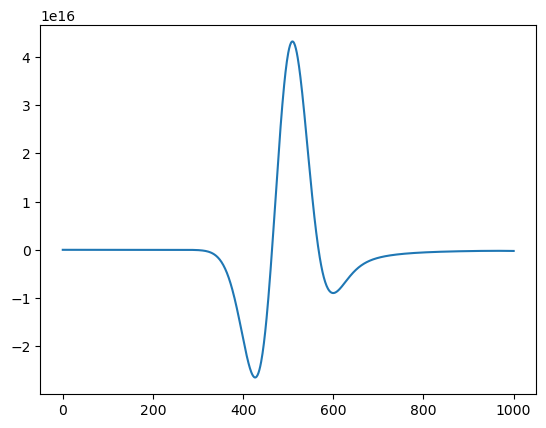

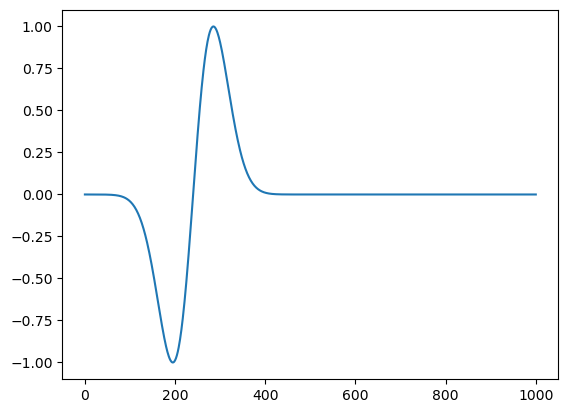

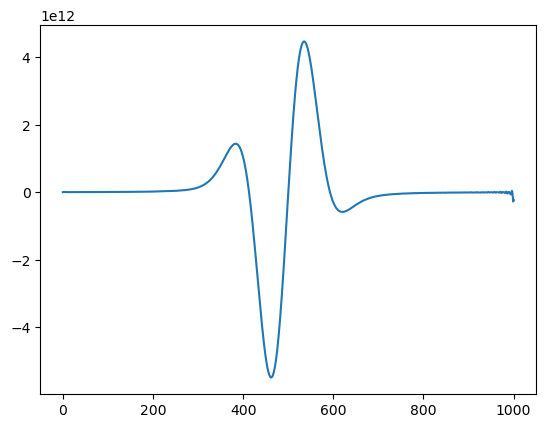

In [33]:
plt.plot(obs_trace[1,:])
plt.show()
plt.plot(src_in_use/np.max(src_in_use))
plt.show()
plt.plot(adj_trace[0,:])
plt.show()